**3.4. ARMA Models**

In \[1\]:

    import inspect
    import time
    import warnings

    import matplotlib.pyplot as plt
    import pandas as pd
    import plotly.express as px
    import seaborn as sns
    from IPython.display import VimeoVideo
    from pymongo import MongoClient
    from sklearn.metrics import mean_absolute_error
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.arima.model import ARIMA

    warnings.filterwarnings("ignore")

In \[2\]:

    VimeoVideo("665851728", h="95c59d2805", width=600)

Out\[2\]:

[](https://vimeo.com/665851728)

Play



# Prepare Data<a href="#Prepare-Data" class="anchor-link">¶</a>

## Import<a href="#Import" class="anchor-link">¶</a>

**Task 3.4.1:** Complete to the create a client to connect to the
MongoDB server, assigns the `"air-quality"` database to `db`, and
assigned the `"nairobi"` connection to `nairobi`.

-   Create a client object for a <span id="tool">MongoDB</span>
    instance.
-   Access a database using
    PyMongo.
-   Access a collection in a database using
    PyMongo.

In \[3\]:

    client = MongoClient(host="localhost", port=27017)
    db = client["air-quality"]
    nairobi = db["nairobi"]

In \[4\]:

    def wrangle(collection, resample_rule="1H"):

        results = collection.find(
            {"metadata.site": 29, "metadata.measurement": "P2"},
            projection={"P2": 1, "timestamp": 1, "_id": 0},
        )

        # Read results into DataFrame
        df = pd.DataFrame(list(results)).set_index("timestamp")

        # Localize timezone
        df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

        # Remove outliers
        df = df[df["P2"] < 500]

        # Resample and forward-fill
        y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")

        return y

In \[5\]:

    VimeoVideo("665851670", h="3efc0c20d4", width=600)

Out\[5\]:

[](https://vimeo.com/665851670)

Play



**Task 3.4.2:** Change your `wrangle` function so that it has a
`resample_rule` argument that allows the user to change the resampling
interval. The argument default should be `"1H"`.

-   What's an
    argument?
-   Include an argument in a function in
    Python.

In \[6\]:

    # Check your work
    func_params = set(inspect.signature(wrangle).parameters.keys())
    assert func_params == set(
        ["collection", "resample_rule"]
    ), f"Your function should take two arguments: `'collection'`, `'resample_rule'`. Your function takes the following arguments: {func_params}"

**Task 3.4.3:** Use your wrangle function to read the data from the
`nairobi` collection into the Series `y`.

In \[7\]:

    y = wrangle(nairobi, resample_rule="1H")
    y.tail()

Out\[7\]:

    timestamp
    2018-12-31 22:00:00+03:00     7.060833
    2018-12-31 23:00:00+03:00     7.854167
    2019-01-01 00:00:00+03:00     9.755833
    2019-01-01 01:00:00+03:00    12.665000
    2019-01-01 02:00:00+03:00    18.803333
    Freq: H, Name: P2, dtype: float64

In \[8\]:

    # Check your work
    assert isinstance(y, pd.Series), f"`y` should be a Series, not a {type(y)}."
    assert len(y) == 2928, f"`y` should have 2,928 observations, not {len(y)}."
    assert (
        y.isnull().sum() == 0
    ), f"There should be no null values in `y`. Your `y` has {y.isnull().sum()} null values."

## Explore<a href="#Explore" class="anchor-link">¶</a>

In \[9\]:

    VimeoVideo("665851654", h="687ff8d5ee", width=600)

Out\[9\]:

[](https://vimeo.com/665851654)

Play



**Task 3.4.4:** Create an ACF plot for the data in `y`. Be sure to label
the x-axis as `"Lag [hours]"` and the y-axis as
`"Correlation Coefficient"`.

-   What's an
    ACF plot?
-   Create an ACF plot using
    statsmodels

In \[10\]:

    fig, ax = plt.subplots(figsize=(15,16))
    plot_acf(y, ax=ax)
    plt.xlabel("Lag [hours]")
    plt.ylabel("Correlation Coefficient");

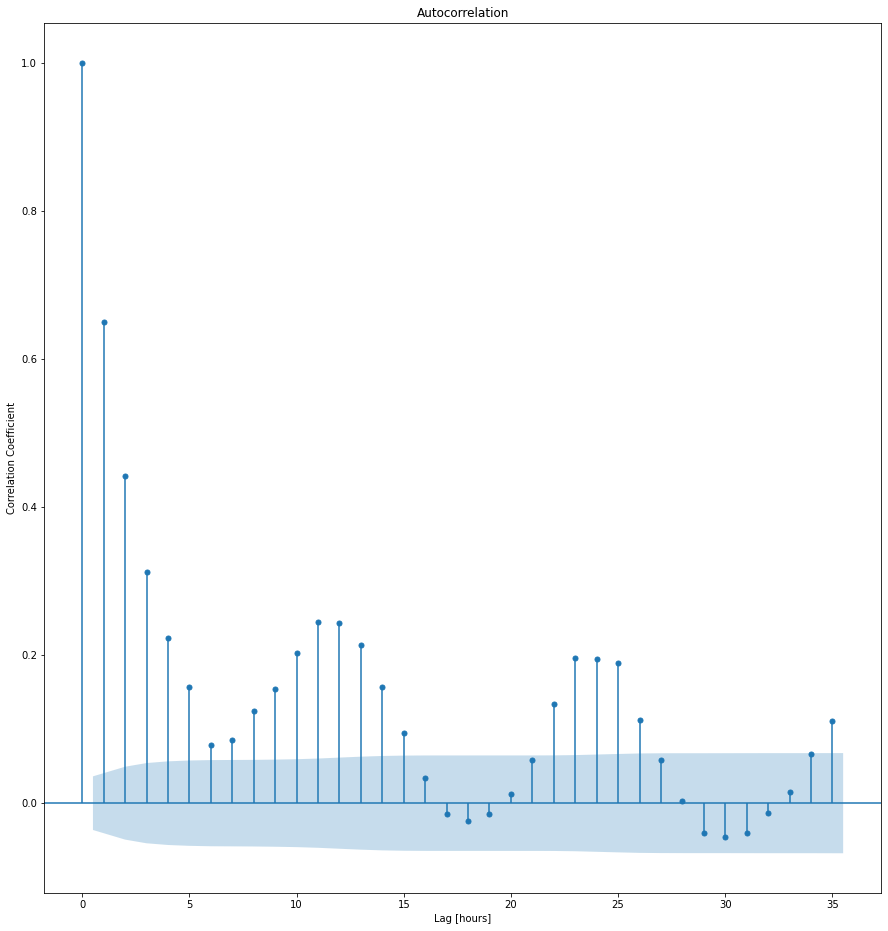

In \[11\]:

    VimeoVideo("665851644", h="e857f05bfb", width=600)

Out\[11\]:

[](https://vimeo.com/665851644)

Play



**Task 3.4.5:** Create an PACF plot for the data in `y`. Be sure to
label the x-axis as `"Lag [hours]"` and the y-axis as
`"Correlation Coefficient"`.

-   What's an
    PACF plot?
-   Create an PACF plot using
    statsmodels

In \[12\]:

    fig, ax = plt.subplots(figsize=(15,16))
    plot_pacf(y, ax=ax)
    plt.xlabel("Lag [hours]")
    plt.ylabel("Correlation Coefficient");

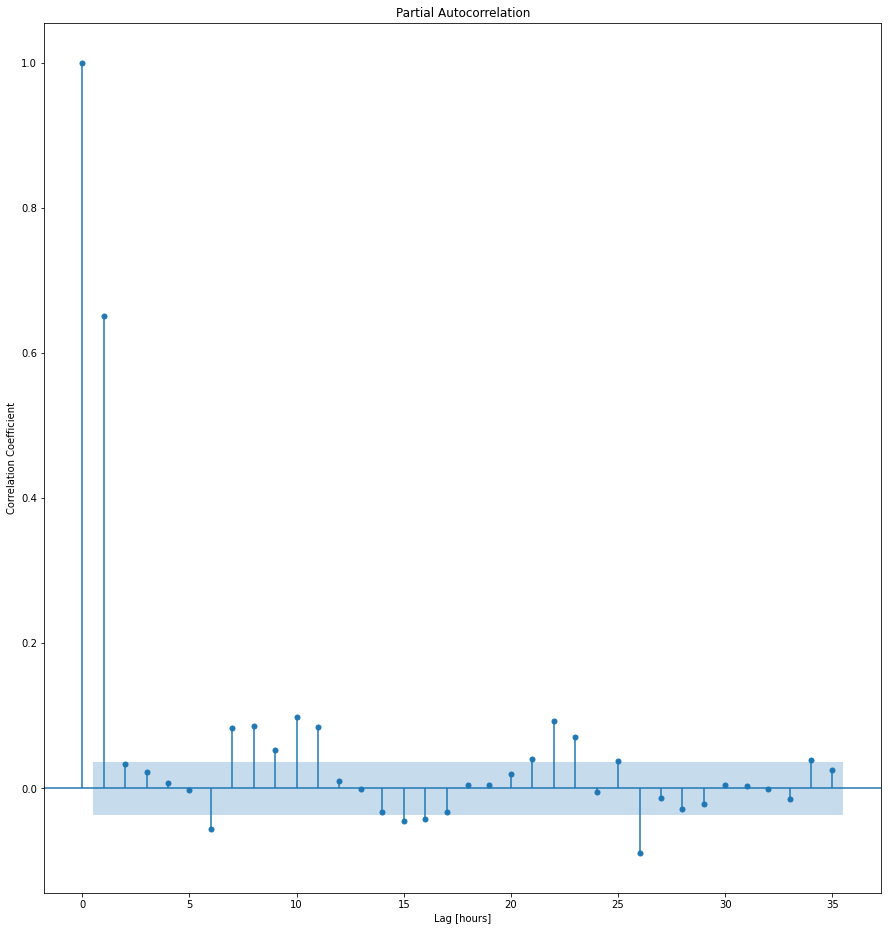

## Split<a href="#Split" class="anchor-link">¶</a>

**Task 3.4.6:** Create a training set `y_train` that contains only
readings from October 2018, and a test set `y_test` that contains
readings from November 1, 2018.

-   Subset a DataFrame by selecting one or more rows in
    pandas.

In \[13\]:

    y_train =  y.get("2018-10")
    y_test = y.get("2018-11-1")
    #y_test.head()

In \[14\]:

    # Check your work
    assert (
        len(y_train) == 744
    ), f"`y_train` should have 744 observations, not {len(y_train)}."
    assert len(y_test) == 24, f"`y_test` should have 24 observations, not {len(y_test)}."

# Build Model<a href="#Build-Model" class="anchor-link">¶</a>

## Baseline<a href="#Baseline" class="anchor-link">¶</a>

**Task 3.4.7:** Calculate the baseline mean absolute error for your
model.

In \[15\]:

    y_train_mean = y_train.mean()
    y_train_pred = [y_train_mean] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_train_pred)
    print("Mean P2 Reading:", round(y_train_mean, 2))
    print("Baseline MAE:", round(mae_baseline, 2))

    Mean P2 Reading: 10.12
    Baseline MAE: 4.17

## Iterate<a href="#Iterate" class="anchor-link">¶</a>

In \[16\]:

    VimeoVideo("665851576", h="36e2dc6269", width=600)

Out\[16\]:

[](https://vimeo.com/665851576)

Play



**Task 3.4.8:** Create ranges for possible \$p\$ and \$q\$ values.
`p_params` should range between 0 and 25, by steps of 8. `q_params`
should range between 0 and 3 by steps of 1.

-   What's a
    hyperparameter?
-   What's an
    iterator?
-   Create a range in
    Python.

In \[17\]:

    p_params = range(0,25,8)
    q_params = range(0,3,1)
    #list(p_params)

In \[18\]:

    VimeoVideo("665851476", h="d60346ed30", width=600)

Out\[18\]:

[](https://vimeo.com/665851476)

Play



**Task 3.4.9:** Complete the code below to train a model with every
combination of hyperparameters in `p_params` and `q_params`. Every time
the model is trained, the mean absolute error is calculated and then
saved to a dictionary. If you're not sure where to start, do the
code-along with Nicholas!

-   What's an
    ARMA model?
-   Append an item to a list in
    Python.
-   Calculate the mean absolute error for a list of predictions in
    scikit-learn.
-   Instantiate a predictor in
    statsmodels.
-   Train a model in
    statsmodels.
-   Write a for loop in
    Python.

In \[19\]:

    # Create dictionary to store MAEs
    mae_grid = dict()
    # Outer loop: Iterate through possible values for `p`
    for p in p_params:
        # Create key-value pair in dict. Key is `p`, value is empty list.
        mae_grid[p] = list()
        # Inner loop: Iterate through possible values for `q`
        for q in q_params:
            # Combination of hyperparameters for model
            order = (p, 0, q)
            # Note start time
            start_time = time.time()
            # Train model
            model = ARIMA(y_train, order=order).fit()
            # Calculate model training time
            elapsed_time = round(time.time() - start_time, 2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
            # Generate in-sample (training) predictions
            y_pred = model.predict()
            # Calculate training MAE
            mae = mean_absolute_error(y_train, y_pred)
            # Append MAE to list in dictionary
            mae_grid[p].append(mae)

    print()
    print(mae_grid)

    Trained ARIMA (0, 0, 0) in 0.39 seconds.
    Trained ARIMA (0, 0, 1) in 0.41 seconds.
    Trained ARIMA (0, 0, 2) in 1.3 seconds.
    Trained ARIMA (8, 0, 0) in 10.4 seconds.
    Trained ARIMA (8, 0, 1) in 41.9 seconds.
    Trained ARIMA (8, 0, 2) in 77.5 seconds.
    Trained ARIMA (16, 0, 0) in 38.31 seconds.
    Trained ARIMA (16, 0, 1) in 133.39 seconds.
    Trained ARIMA (16, 0, 2) in 195.01 seconds.
    Trained ARIMA (24, 0, 0) in 108.08 seconds.
    Trained ARIMA (24, 0, 1) in 126.22 seconds.
    Trained ARIMA (24, 0, 2) in 242.93 seconds.

    {0: [4.171460443827197, 3.3506427433555537, 3.1057222587888647], 8: [2.9384480570404223, 2.9149008203151663, 2.908046094677133], 16: [2.9201084726122, 2.929436207635203, 2.913638894139686], 24: [2.914390327277196, 2.9136013252035013, 2.89792511429827]}

In \[20\]:

    VimeoVideo("665851464", h="12f4080d0b", width=600)

Out\[20\]:

[](https://vimeo.com/665851464)

Play



**Task 3.4.10:** Organize all the MAE's from above in a DataFrame names
`mae_df`. Each row represents a possible value for \$q\$ and each column
represents a possible value for \$p\$.

-   Create a DataFrame from a dictionary using
    pandas.

In \[21\]:

    mae_df = pd.DataFrame(mae_grid)
    mae_df.round(4)

Out\[21\]:

|     | 0      | 8      | 16     | 24     |
|-----|--------|--------|--------|--------|
| 0   | 4.1715 | 2.9384 | 2.9201 | 2.9144 |
| 1   | 3.3506 | 2.9149 | 2.9294 | 2.9136 |
| 2   | 3.1057 | 2.9080 | 2.9136 | 2.8979 |

In \[22\]:

    VimeoVideo("665851453", h="dfd415bc08", width=600)

Out\[22\]:

[](https://vimeo.com/665851453)

Play



**Task 3.4.11:** Create heatmap of the values in `mae_grid`. Be sure to
label your x-axis `"p values"` and your y-axis `"q values"`.

-   Create a heatmap in
    seaborn.

In \[23\]:

    sns.heatmap(mae_df,cmap="Blues")
    plt.xlabel("p values")
    plt.ylabel("q values")
    plt.title("ARMA Grid Search (Criterion: MAE)");

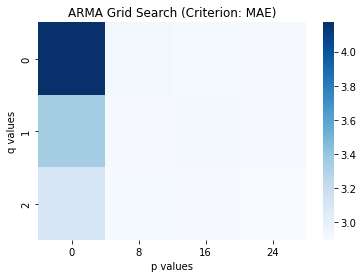

In \[24\]:

    VimeoVideo("665851444", h="8b58161f26", width=600)

Out\[24\]:

[](https://vimeo.com/665851444)

Play



**Task 3.4.12:** Use the
[`plot_diagnostics`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html)
method to check the residuals for your model. Keep in mind that the plot
will represent the residuals from the last model you trained, so make
sure it was your best model, too!

-   Examine time series model residuals using
    statsmodels.

In \[25\]:

    fig, ax = plt.subplots(figsize=(15, 12))
    model.plot_diagnostics(fig=fig);

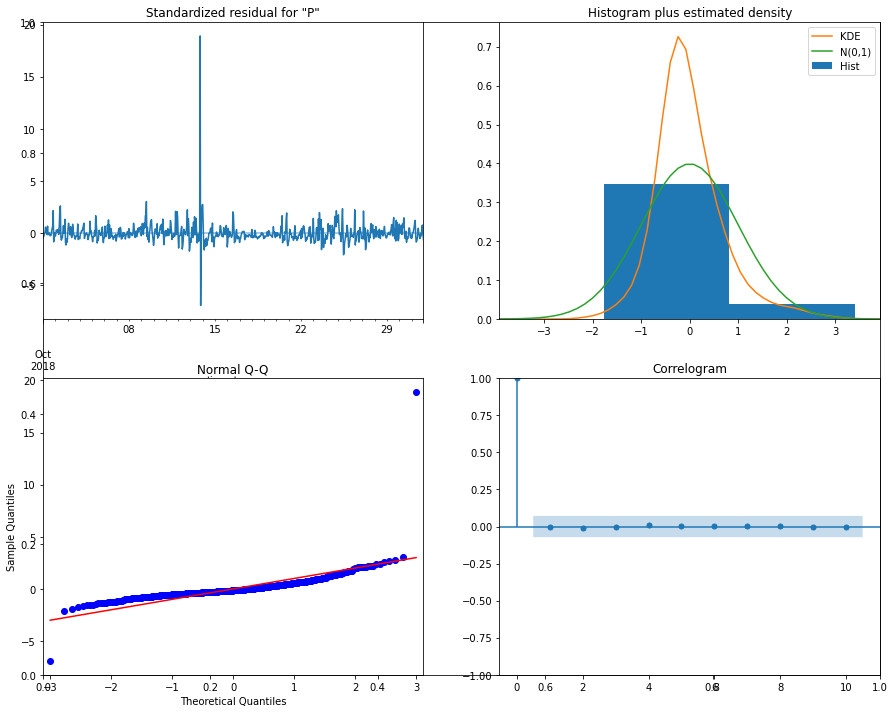

## Evaluate<a href="#Evaluate" class="anchor-link">¶</a>

In \[26\]:

    VimeoVideo("665851439", h="c48d80cdf4", width=600)

Out\[26\]:

[](https://vimeo.com/665851439)

Play



**Task 3.4.13:** Complete the code below to perform walk-forward
validation for your model for the entire test set `y_test`. Store your
model's predictions in the Series `y_pred_wfv`. Choose the values for
\$p\$ and \$q\$ that best balance model performance and computation
time. Remember: This model is going to have to train 24 times before you
can see your test MAE!

In \[31\]:

    y_pred_wfv = pd.Series()
    history = y_train.copy()
    for i in range(len(y_test)):
        model = ARIMA(history, order=(8,0,1)).fit()
        next_pred = model.forecast()
        y_pred_wfv = y_pred_wfv.append(next_pred)
        history = history.append(y_test[next_pred.index])

In \[30\]:

    test_mae = mean_absolute_error(y_test, y_pred_wfv)
    print("Test MAE (walk forward validation):", round(test_mae, 2))

    Test MAE (walk forward validation): 1.67

# Communicate Results<a href="#Communicate-Results" class="anchor-link">¶</a>

In \[32\]:

    VimeoVideo("665851423", h="8236ff348f", width=600)

Out\[32\]:

[](https://vimeo.com/665851423)

Play



**Task 3.4.14:** First, generate the list of training predictions for
your model. Next, create a DataFrame `df_predictions` with the true
values `y_test` and your predictions `y_pred_wfv` (don't forget the
index). Finally, plot `df_predictions` using plotly express. Make sure
that the y-axis is labeled `"P2"`.

-   Generate in-sample predictions for a model in
    statsmodels.
-   Create a DataFrame from a dictionary using
    pandas.
-   Create a line plot in
    pandas.

In \[34\]:

    df_predictions = pd.DataFrame({"y_test":y_test, "y_pred_wfv":y_pred_wfv})
    fig = px.line(df_predictions, labels={"value": "PM2.5"})
    fig.show()

------------------------------------------------------------------------

Copyright © 2022 WorldQuant University. This content is licensed solely
for personal use. Redistribution or publication of this material is
strictly prohibited.